In [3]:
from PASTE2 import *
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import math
import tqdm

/home/lih0m/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-03 15:42:29.776897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 15:42:30.590864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lih0m/std-poisson/libboost_log.so.1.80.0:/home/lih0m/std-poisson/local/lib::/home/lih0m/cuda-11.2/lib64
2024-04-03 15:42:30.591003: W tensorflow/compi

In [5]:
def simulate_stitching(adata,axis = 0, from_low = True, threshold = 0.5):
    cadata = adata.copy()
    coo = cadata.obsm['spatial']
    scale = np.max(coo[:, axis]) - np.min(coo[:, axis])
    if from_low:
        chosen_indices = coo[:,axis] > (scale * threshold + np.min(coo[:, axis]))
    else:
        chosen_indices = coo[:,axis] < (np.max(coo[:, axis]) - scale * threshold)
    cadata = cadata[chosen_indices,:]
    return cadata
def partial_slice_alignment(
    slices,
    spatial_key= "spatial",
    key_added = "align_spatial",
    alpha = 0.1,
    s = 0.5
):
    """Align spatial coordinates of slices.
    Args:
        slices: List of slices (AnnData Object).
        spatial_key: The key in `.obsm` that corresponds to the raw spatial coordinate.
        key_added: adata.obsm key under which to add the registered spatial coordinate.
        alpha: Trade-off parameter (0 < alpha < 1).
        numItermax: Max number of iterations for cg.
        numItermaxEmd: Max number of iterations for emd.
        device: Equipment used to run the program.
            Can also accept a torch.device. E.g.: 'cuda:0'
    Returns:
        List of slices (AnnData Object) after alignment.
    """
    for sub_slice in slices:
        sub_slice.obsm[key_added] = sub_slice.obsm[spatial_key]

    align_slices = []
    slice1 = slices[0].copy()
    slice2 = slices[1].copy()

    # Calculate and returns optimal alignment of two slices.
    pi = partial_pairwise_align(
        slice1,
        slice2,
        s=s,
        alpha=alpha
    )

    # Calculate new coordinates of two slices
    raw_slice1_coords, raw_slice2_coords = (
        slice1.obsm[key_added],
        slice2.obsm[key_added],
    )
    slice1_coords = raw_slice1_coords - pi.sum(axis=1).dot(raw_slice1_coords)
    slice2_coords = raw_slice2_coords - pi.sum(axis=0).dot(raw_slice2_coords)
    H = slice2_coords.T.dot(pi.T.dot(slice1_coords))
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T.dot(U.T)
    slice2_coords = R.dot(slice2_coords.T).T
    slice1.obsm[key_added] = np.around(slice1_coords, decimals=2)
    slice2.obsm[key_added] = np.around(slice2_coords, decimals=2)


    align_slices.append(slice1)
    align_slices.append(slice2)

    for i, align_slice in enumerate(align_slices):
        align_slice.obs["x"] = align_slice.obsm[key_added][:, 0].astype(float)
        align_slice.obs["y"] = align_slice.obsm[key_added][:, 1].astype(float)

    return align_slices,R

PASTE2 starts...
Starting GLM-PCA...
Iteration: 0 | deviance=1.4961E+7
Iteration: 1 | deviance=1.4961E+7
Iteration: 2 | deviance=1.4214E+7
Iteration: 3 | deviance=1.3829E+7
Iteration: 4 | deviance=1.3652E+7
Iteration: 5 | deviance=1.3567E+7
Iteration: 6 | deviance=1.3522E+7
Iteration: 7 | deviance=1.3492E+7
Iteration: 8 | deviance=1.3470E+7
Iteration: 9 | deviance=1.3454E+7
GLM-PCA finished.
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.619083e+01|0.000000e+00|0.000000e+00
    1|7.617590e+00|6.376458e+00|4.857324e+01
    2|6.027506e+00|2.638046e-01|1.590084e+00
    3|5.705538e+00|5.643074e-02|3.219677e-01
    4|5.699274e+00|1.099095e-03|6.264043e-03
    5|5.698215e+00|1.858434e-04|1.058976e-03
    6|5.697656e+00|9.820767e-05|5.595535e-04
    7|5.697482e+00|3.042203e-05|1.733290e-04
    8|5.697395e+00|1.528500e-05|8.708467e-05
    9|5.697369e+00|4.571682e-06|2.604656e-05
   10|5.697356e+00|2.277088e-06|1.297338e-05
   11|5.697347

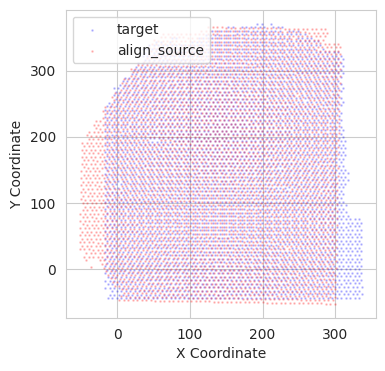

In [7]:
train_ad1 = sc.read_h5ad('./Dataset/151507_preprocessed.h5')
train_ad2 = sc.read_h5ad('./Dataset/151508_preprocessed.h5')
train_ad1.X = np.array(train_ad1.X.todense())
train_ad2.X = np.array(train_ad2.X.todense())

adata1 = simulate_stitching(train_ad1, axis=0, from_low=True, threshold=0.1)
adata2 = simulate_stitching(train_ad2, axis=0, from_low=False, threshold=0.1)
train_ad1_part_overlap_index = adata1.obsm['spatial'][:,0] < np.max(adata2.obsm['spatial'][:,0])
train_ad2_part_overlap_index = adata2.obsm['spatial'][:,0] > np.min(adata1.obsm['spatial'][:,0])

src_cor = np.array(adata1.obsm['spatial'])
tgt_cor = np.array(adata2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)
adata1.obsm['spatial'] = src_cor
adata2.obsm['spatial'] = tgt_cor


align_adatas,R = partial_slice_alignment(
        slices = [adata1,adata2],
        spatial_key = "spatial",
        key_added = "align_spatial",
        alpha = 0.1
)

plt.figure(figsize=(4,4))
plt.scatter(align_adatas[0].obsm['align_spatial'][:,0],align_adatas[0].obsm['align_spatial'][:,1],c='b',label='target',alpha=0.2,s=0.8)
plt.scatter(align_adatas[1].obsm['align_spatial'][:,0],align_adatas[1].obsm['align_spatial'][:,1],c='r',label='align_source',alpha=0.2,s=0.8)
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()
plt.show()